# Proyek Klasifikasi Gambar: Vegetable Image Classification
- **Nama:** Optra Dananjaya
- **Email:** Optradananjaya@gmail.com
- **ID Dicoding:** mrhmerah


## Import Semua Packages/Library yang Digunakan

In [1]:
!pip install tensorflowjs

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.1/89.1 kB 861.3 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.0/53.0 kB 4.0 MB/s eta 0:00:00
  Attempting uninstall: packaging
    Found existing installation: packaging 24.2
    Uninstalling packaging-24.2:
      Successfully uninstalled packaging-24.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-cloud-bigquery 3.31.0 requires packaging>=24.2.0, but you have packaging 23.2 which is incompatible.


In [2]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [3]:
from google.colab import files
import os
import numpy as np
from PIL import Image
from tqdm import tqdm
import cv2
import random
import matplotlib.pyplot as plt

In [4]:
from sklearn.preprocessing import LabelEncoder
from keras.utils import to_categorical
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.layers import Activation
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam

## Data Preparation

In [19]:
files.upload()

Saving kaggle.json to kaggle (1).json


{'kaggle (1).json': b'{"username":"optradananjaya","key":"bec34993c5d24959b7ab343ed30700f7"}'}

In [6]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [7]:
!kaggle datasets download misrakahmed/vegetable-image-dataset

Dataset URL: https://www.kaggle.com/datasets/misrakahmed/vegetable-image-dataset
License(s): CC-BY-SA-4.0


In [8]:
!unzip vegetable-image-dataset.zip

Streaming output truncated to the last 5000 lines.
  inflating: Vegetable Images/train/Radish/0001.jpg  
  inflating: Vegetable Images/train/Radish/0002.jpg  
  inflating: Vegetable Images/train/Radish/0003.jpg  
  inflating: Vegetable Images/train/Radish/0004.jpg  
  inflating: Vegetable Images/train/Radish/0005.jpg  
  inflating: Vegetable Images/train/Radish/0006.jpg  
  inflating: Vegetable Images/train/Radish/0007.jpg  
  inflating: Vegetable Images/train/Radish/0008.jpg  
  inflating: Vegetable Images/train/Radish/0009.jpg  
  inflating: Vegetable Images/train/Radish/0010.jpg  
  inflating: Vegetable Images/train/Radish/0011.jpg  
  inflating: Vegetable Images/train/Radish/0012.jpg  
  inflating: Vegetable Images/train/Radish/0013.jpg  
  inflating: Vegetable Images/train/Radish/0014.jpg  
  inflating: Vegetable Images/train/Radish/0015.jpg  
  inflating: Vegetable Images/train/Radish/0016.jpg  
  inflating: Vegetable Images/train/Radish/0017.jpg  
  inflating: Vegetable Images/t

In [9]:
def print_images_resolution(directory):
    unique_sizes = set()
    total_images = 0

    for subdir in os.listdir(directory):
        subdir_path = os.path.join(directory, subdir)
        image_files = os.listdir(subdir_path)
        num_images = len(image_files)
        print(f"{subdir}: {num_images}")
        total_images += num_images

        for img_file in image_files:
            img_path = os.path.join(subdir_path, img_file)
            with Image.open(img_path) as img:
                unique_sizes.add(img.size)

        for size in unique_sizes:
            print(f"- {size}")
        print("---------------")

    print(f"\nTotal: {total_images}")

print_images_resolution('Vegetable Images/test')
print_images_resolution('Vegetable Images/train')
print_images_resolution('Vegetable Images/validation')

Cucumber: 200
- (224, 224)
---------------
Pumpkin: 200
- (224, 224)
---------------
Brinjal: 200
- (224, 224)
---------------
Capsicum: 200
- (224, 224)
---------------
Tomato: 200
- (224, 224)
---------------
Bottle_Gourd: 200
- (224, 224)
---------------
Bean: 200
- (224, 224)
---------------
Papaya: 200
- (224, 224)
- (224, 207)
---------------
Radish: 200
- (224, 224)
- (224, 207)
---------------
Bitter_Gourd: 200
- (224, 224)
- (224, 207)
---------------
Broccoli: 200
- (224, 224)
- (224, 207)
---------------
Cauliflower: 200
- (224, 224)
- (224, 207)
---------------
Cabbage: 200
- (224, 224)
- (224, 207)
---------------
Carrot: 200
- (224, 224)
- (224, 207)
---------------
Potato: 200
- (224, 224)
- (224, 207)
---------------

Total: 3000
Cucumber: 1000
- (224, 224)
---------------
Pumpkin: 1000
- (224, 224)
---------------
Brinjal: 1000
- (224, 224)
---------------
Capsicum: 1000
- (224, 224)
---------------
Tomato: 1000
- (224, 224)
---------------
Bottle_Gourd: 1000
- (224, 2

### Data Loading

In [10]:
base_dir = 'Vegetable Images'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')

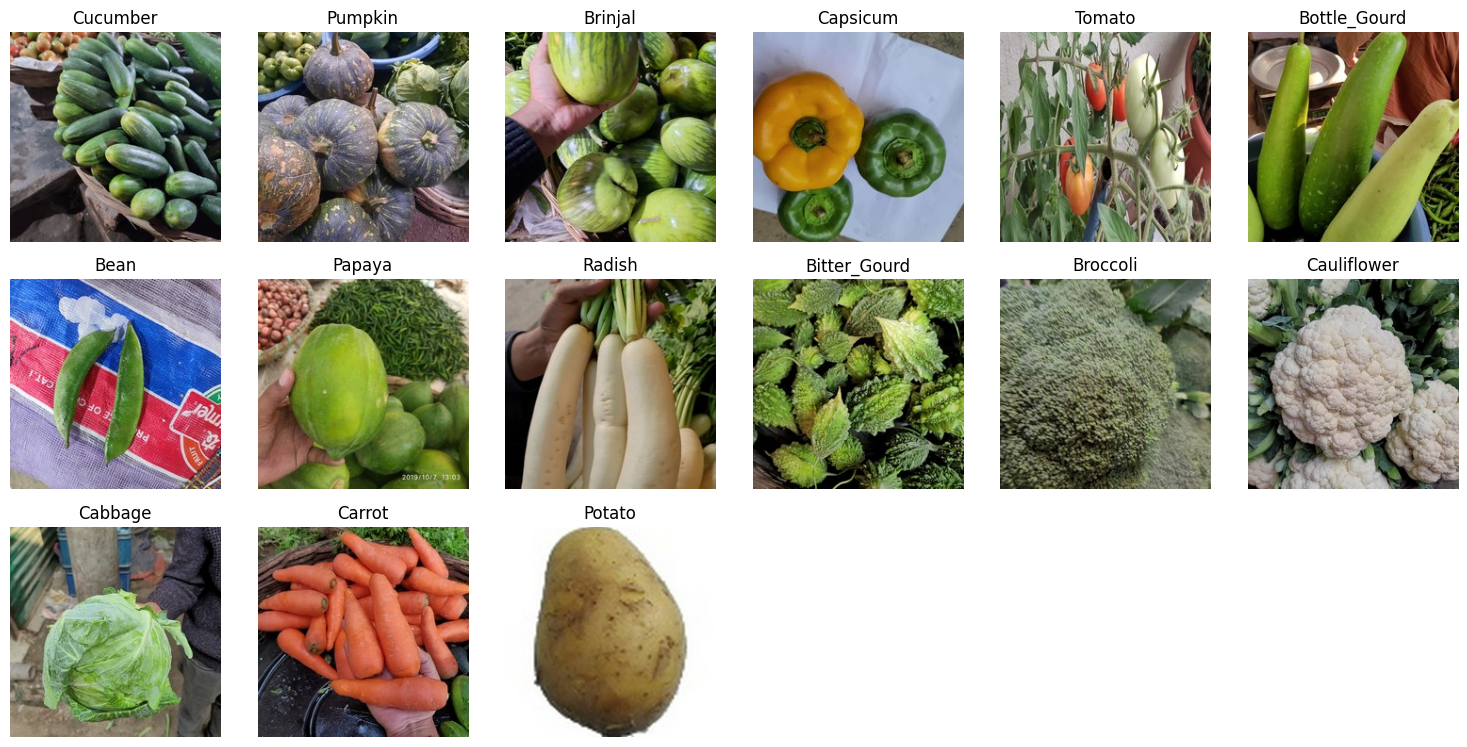

In [11]:
def visualize_images(base_dir):
    """Menampilkan satu gambar per label."""

    plt.figure(figsize=(15, 15))

    for i, label in enumerate(os.listdir(base_dir)):
        label_dir = os.path.join(base_dir, label)
        if os.path.isdir(label_dir):
            image_files = [f for f in os.listdir(label_dir) if os.path.isfile(os.path.join(label_dir, f))]
            if image_files:
                random_image = random.choice(image_files)
                image_path = os.path.join(label_dir, random_image)
                image = plt.imread(image_path)

                plt.subplot(6, 6, i + 1)
                plt.imshow(image)
                plt.title(label)
                plt.axis('off')

    plt.tight_layout()
    plt.show()

visualize_images(train_dir)

In [12]:
import os

def print_dataset_info(base_dir):
    """Menampilkan informasi tentang dataset."""

    print(f"Informasi Dataset untuk {os.path.basename(base_dir)}:")

    total_images = 0
    label_counts = {}

    for label in os.listdir(base_dir):
        label_dir = os.path.join(base_dir, label)
        if os.path.isdir(label_dir):
            num_images = len([f for f in os.listdir(label_dir) if os.path.isfile(os.path.join(label_dir, f))])
            total_images += num_images
            label_counts[label] = num_images

    print(f"Total Gambar: {total_images}")
    print("Jumlah Gambar per Label:")
    for label, count in label_counts.items():
        print(f"- {label}: {count}")
    print("-" * 20)

print_dataset_info(train_dir)
print_dataset_info(validation_dir)
print_dataset_info(test_dir)

Informasi Dataset untuk train:
Total Gambar: 15000
Jumlah Gambar per Label:
- Cucumber: 1000
- Pumpkin: 1000
- Brinjal: 1000
- Capsicum: 1000
- Tomato: 1000
- Bottle_Gourd: 1000
- Bean: 1000
- Papaya: 1000
- Radish: 1000
- Bitter_Gourd: 1000
- Broccoli: 1000
- Cauliflower: 1000
- Cabbage: 1000
- Carrot: 1000
- Potato: 1000
--------------------
Informasi Dataset untuk validation:
Total Gambar: 3000
Jumlah Gambar per Label:
- Cucumber: 200
- Pumpkin: 200
- Brinjal: 200
- Capsicum: 200
- Tomato: 200
- Bottle_Gourd: 200
- Bean: 200
- Papaya: 200
- Radish: 200
- Bitter_Gourd: 200
- Broccoli: 200
- Cauliflower: 200
- Cabbage: 200
- Carrot: 200
- Potato: 200
--------------------
Informasi Dataset untuk test:
Total Gambar: 3000
Jumlah Gambar per Label:
- Cucumber: 200
- Pumpkin: 200
- Brinjal: 200
- Capsicum: 200
- Tomato: 200
- Bottle_Gourd: 200
- Bean: 200
- Papaya: 200
- Radish: 200
- Bitter_Gourd: 200
- Broccoli: 200
- Cauliflower: 200
- Cabbage: 200
- Carrot: 200
- Potato: 200
-----------

### Data Preprocessing

Menggabungkan seluruh dataset karena dataset awal sudah dipisah berdasarkan test, train, dan validation


In [13]:
!mkdir all_data

In [14]:
base_dir = 'Vegetable Images'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')

all_data_dir = 'all_data'

os.makedirs(all_data_dir, exist_ok=True)

# Fungsi untuk menggabungkan data dari folder sumber ke folder tujuan
def merge_data(source_dir, destination_dir):
    for class_name in os.listdir(source_dir):
        class_dir = os.path.join(source_dir, class_name)
        destination_class_dir = os.path.join(destination_dir, class_name)
        os.makedirs(destination_class_dir, exist_ok=True)
        for filename in os.listdir(class_dir):
            shutil.copy(os.path.join(class_dir, filename),
                        os.path.join(destination_class_dir, filename))

merge_data(train_dir, all_data_dir)
merge_data(validation_dir, all_data_dir)
merge_data(test_dir, all_data_dir)

print("Data telah digabungkan ke dalam folder 'all_data'.")

Data telah digabungkan ke dalam folder 'all_data'.


In [15]:
import os

def print_dataset_info(base_dir):
    """Menampilkan informasi tentang dataset."""

    print(f"Informasi Dataset untuk {os.path.basename(base_dir)}:")

    total_images = 0
    label_counts = {}

    for label in os.listdir(base_dir):
        label_dir = os.path.join(base_dir, label)
        if os.path.isdir(label_dir):
            num_images = len([f for f in os.listdir(label_dir) if os.path.isfile(os.path.join(label_dir, f))])
            total_images += num_images
            label_counts[label] = num_images

    print(f"Total Gambar: {total_images}")
    print("Jumlah Gambar per Label:")
    for label, count in label_counts.items():
        print(f"- {label}: {count}")
    print("-" * 20)

print_dataset_info('all_data')

Informasi Dataset untuk all_data:
Total Gambar: 21000
Jumlah Gambar per Label:
- Cucumber: 1400
- Pumpkin: 1400
- Brinjal: 1400
- Capsicum: 1400
- Tomato: 1400
- Bottle_Gourd: 1400
- Bean: 1400
- Papaya: 1400
- Radish: 1400
- Bitter_Gourd: 1400
- Broccoli: 1400
- Cauliflower: 1400
- Cabbage: 1400
- Carrot: 1400
- Potato: 1400
--------------------


#### Split Dataset

In [16]:
all_data_dir = 'all_data'

train_dir = 'train'
validation_dir = 'validation'
test_dir = 'test'

train_ratio = 0.7
validation_ratio = 0.15
test_ratio = 0.15

for class_name in os.listdir(all_data_dir):
    class_dir = os.path.join(all_data_dir, class_name)
    images = os.listdir(class_dir)

    train_images, temp_images = train_test_split(images, test_size=1 - train_ratio, random_state=42)
    validation_images, test_images = train_test_split(temp_images, test_size=test_ratio / (test_ratio + validation_ratio), random_state=42)

    os.makedirs(os.path.join(train_dir, class_name), exist_ok=True)
    os.makedirs(os.path.join(validation_dir, class_name), exist_ok=True)
    os.makedirs(os.path.join(test_dir, class_name), exist_ok=True)

    for image in train_images:
        shutil.move(os.path.join(class_dir, image), os.path.join(train_dir, class_name, image))
    for image in validation_images:
        shutil.move(os.path.join(class_dir, image), os.path.join(validation_dir, class_name, image))
    for image in test_images:
        shutil.move(os.path.join(class_dir, image), os.path.join(test_dir, class_name, image))

print("Split data selesai.")

Split data selesai.


In [17]:
import os

def print_dataset_info(base_dir):
    """Menampilkan informasi tentang dataset."""

    print(f"Informasi Dataset untuk {os.path.basename(base_dir)}:")

    total_images = 0
    label_counts = {}

    for label in os.listdir(base_dir):
        label_dir = os.path.join(base_dir, label)
        if os.path.isdir(label_dir):
            num_images = len([f for f in os.listdir(label_dir) if os.path.isfile(os.path.join(label_dir, f))])
            total_images += num_images
            label_counts[label] = num_images

    print(f"Total Gambar: {total_images}")
    print("Jumlah Gambar per Label:")
    for label, count in label_counts.items():
        print(f"- {label}: {count}")
    print("-" * 20)

print_dataset_info('train')
print_dataset_info('validation')
print_dataset_info('test')

Informasi Dataset untuk train:
Total Gambar: 14685
Jumlah Gambar per Label:
- Cucumber: 979
- Pumpkin: 979
- Brinjal: 979
- Capsicum: 979
- Tomato: 979
- Bottle_Gourd: 979
- Bean: 979
- Papaya: 979
- Radish: 979
- Bitter_Gourd: 979
- Broccoli: 979
- Cauliflower: 979
- Cabbage: 979
- Carrot: 979
- Potato: 979
--------------------
Informasi Dataset untuk validation:
Total Gambar: 3150
Jumlah Gambar per Label:
- Cucumber: 210
- Pumpkin: 210
- Brinjal: 210
- Capsicum: 210
- Tomato: 210
- Bottle_Gourd: 210
- Bean: 210
- Papaya: 210
- Radish: 210
- Bitter_Gourd: 210
- Broccoli: 210
- Cauliflower: 210
- Cabbage: 210
- Carrot: 210
- Potato: 210
--------------------
Informasi Dataset untuk test:
Total Gambar: 3165
Jumlah Gambar per Label:
- Cucumber: 211
- Pumpkin: 211
- Brinjal: 211
- Capsicum: 211
- Tomato: 211
- Bottle_Gourd: 211
- Bean: 211
- Papaya: 211
- Radish: 211
- Bitter_Gourd: 211
- Broccoli: 211
- Cauliflower: 211
- Cabbage: 211
- Carrot: 211
- Potato: 211
--------------------


In [18]:
# Augmentasi data training
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Rescaling data validation
validation_datagen = ImageDataGenerator(rescale=1./255)

# Rescaling data test
test_datagen = ImageDataGenerator(rescale=1./255)

# Membuat generator data
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(150, 150),
    batch_size=128,
    class_mode='categorical'
)

validation_generator = validation_datagen.flow_from_directory(
    validation_dir,
    target_size=(150, 150),
    batch_size=128,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(150, 150),
    batch_size=128,
    class_mode='categorical',
    shuffle=False
)

# Petakan indeks kelas ke nama kelas
class_map = dict([(v, k) for k, v in train_generator.class_indices.items()])
print(class_map)

Found 14685 images belonging to 15 classes.
Found 3150 images belonging to 15 classes.
Found 3165 images belonging to 15 classes.
{0: 'Bean', 1: 'Bitter_Gourd', 2: 'Bottle_Gourd', 3: 'Brinjal', 4: 'Broccoli', 5: 'Cabbage', 6: 'Capsicum', 7: 'Carrot', 8: 'Cauliflower', 9: 'Cucumber', 10: 'Papaya', 11: 'Potato', 12: 'Pumpkin', 13: 'Radish', 14: 'Tomato'}


## Modelling

In [20]:
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)),
    MaxPooling2D(2, 2),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Flatten(),
    Dense(512, activation='relu'),
    Dense(15, activation='softmax')
])

model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 148, 148, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 74, 74, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 72, 72, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 36, 36, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 34, 34, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 17, 17, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 36992)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │    18,940,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 15)             │         7,695 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 19,041,359 (72.64 MB)

 Trainable params: 19,041,359 (72.64 MB)

 Non-trainable params: 0 (0.00 B)

In [21]:
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.0001)

model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

steps_per_epoch = train_generator.samples // train_generator.batch_size
validation_steps = validation_generator.samples // validation_generator.batch_size

hist = model.fit(
    train_generator,
    epochs=100,
    verbose=1,
    validation_data=validation_generator,
    steps_per_epoch=steps_per_epoch,
    validation_steps=validation_steps,
    callbacks=[early_stopping, reduce_lr]
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/100
114/114 ━━━━━━━━━━━━━━━━━━━━ 111s 889ms/step - accuracy: 0.2687 - loss: 2.2693 - val_accuracy: 0.7109 - val_loss: 0.9012 - learning_rate: 0.0010
Epoch 2/100
  1/114 ━━━━━━━━━━━━━━━━━━━━ 12s 108ms/step - accuracy: 0.6094 - loss: 1.2178

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


114/114 ━━━━━━━━━━━━━━━━━━━━ 4s 34ms/step - accuracy: 0.6094 - loss: 1.2178 - val_accuracy: 0.6826 - val_loss: 0.9376 - learning_rate: 0.0010
Epoch 3/100
114/114 ━━━━━━━━━━━━━━━━━━━━ 121s 811ms/step - accuracy: 0.6846 - loss: 0.9468 - val_accuracy: 0.8180 - val_loss: 0.5498 - learning_rate: 0.0010
Epoch 4/100
114/114 ━━━━━━━━━━━━━━━━━━━━ 5s 40ms/step - accuracy: 0.7578 - loss: 0.7537 - val_accuracy: 0.8571 - val_loss: 0.4553 - learning_rate: 0.0010
Epoch 5/100
114/114 ━━━━━━━━━━━━━━━━━━━━ 95s 833ms/step - accuracy: 0.7982 - loss: 0.6094 - val_accuracy: 0.8590 - val_loss: 0.4229 - learning_rate: 0.0010
Epoch 6/100
114/114 ━━━━━━━━━━━━━━━━━━━━ 5s 40ms/step - accuracy: 0.8281 - loss: 0.4556 - val_accuracy: 0.8473 - val_loss: 0.4570 - learning_rate: 0.0010
Epoch 7/100
114/114 ━━━━━━━━━━━━━━━━━━━━ 93s 818ms/step - accuracy: 0.8609 - loss: 0.4356 - val_accuracy: 0.8848 - val_loss: 0.3409 - learning_rate: 0.0010
Epoch 8/100
114/114 ━━━━━━━━━━━━━━━━━━━━ 4s 36ms/step - accuracy: 0.9219 - loss: 

## Evaluasi dan Visualisasi

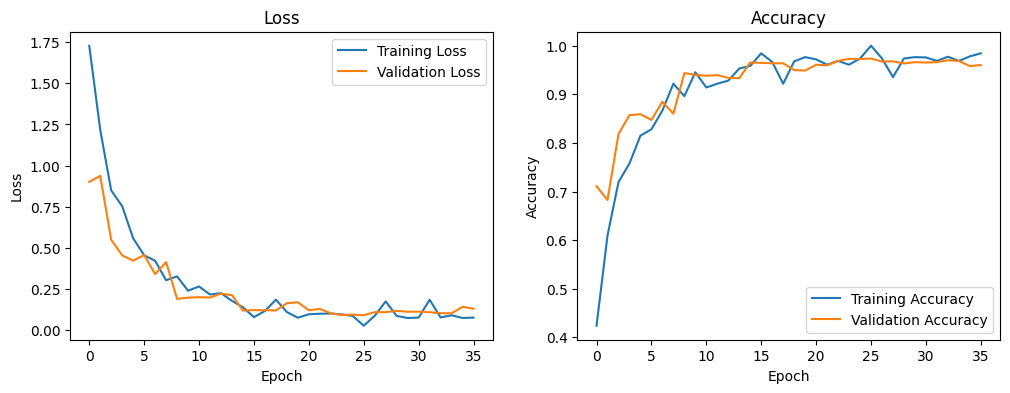

In [22]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(hist.history['loss'], label='Training Loss')
plt.plot(hist.history['val_loss'], label='Validation Loss')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(hist.history['accuracy'], label='Training Accuracy')
plt.plot(hist.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [23]:
# Evaluasi model menggunakan data test
loss, accuracy = model.evaluate(test_generator, verbose=1)

print(f"Loss: {loss:.4f}")
print(f"Accuracy: {accuracy:.4f}")

25/25 ━━━━━━━━━━━━━━━━━━━━ 6s 243ms/step - accuracy: 0.9741 - loss: 0.0913
Loss: 0.1044
Accuracy: 0.9722


## Konversi Model

In [24]:
# Menyimpan model dalam format SavedModel
save_path = os.path.join("models/SavedModel/")
tf.saved_model.save(model, save_path)

In [25]:
# Menyimpan model dalam format TF-Lite
os.makedirs('tflite_model', exist_ok=True)
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

with open("tflite_model/converted_model.tflite", "wb") as f:
    f.write(tflite_model)

class_names = list(train_generator.class_indices.keys())

# Simpan nama kelas ke dalam file label.txt
with open("tflite_model/label.txt", "w") as f:
    for class_name in class_names:
        f.write(class_name + "\n")

Saved artifact at '/tmp/tmpvnkfwhuw'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 150, 150, 3), dtype=tf.float32, name='keras_tensor')
Output Type:
  TensorSpec(shape=(None, 15), dtype=tf.float32, name=None)
Captures:
  140445108367440: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140445108365712: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140445108366864: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140445108367248: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140445108364368: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140445108370320: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140445108370896: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140445108368016: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140445108369360: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140445108363792: TensorSpec(shape=(), dtype=tf.resource, name=None)


In [26]:
# Menyimpan model dalam format TFJS
model.save("model.h5")  # Simpan dulu ke format .h5
!tensorflowjs_converter --input_format=keras model.h5 tfjs_model

2025-04-22 06:35:43.980613: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1745303744.001450   15684 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1745303744.007436   15684 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
🌲 Try https://ydf.readthedocs.io, the successor of TensorFlow Decision Forests with more features and faster training!
failed to lookup keras version from the file,
    this is likely a weight only file


## Inference (Optional)

In [28]:
import tensorflow as tf
import numpy as np
import cv2

model_path = 'tflite_model/converted_model.tflite'
label_path = 'tflite_model/label.txt'

interpreter = tf.lite.Interpreter(model_path=model_path)
interpreter.allocate_tensors()

# Muat label dari file label.txt
with open(label_path, 'r') as f:
    labels = [line.strip() for line in f.readlines()]

img_path = '/content/test/Broccoli/0049.jpg'

img = cv2.imread(img_path)
img = cv2.resize(img, (150, 150))
img = img / 255.0
input_data = np.expand_dims(img, axis=0).astype(np.float32)

# Lakukan inference
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()
interpreter.set_tensor(input_details[0]['index'], input_data)
interpreter.invoke()
output_data = interpreter.get_tensor(output_details[0]['index'])

predicted_class = np.argmax(output_data)
predicted_class_name = labels[predicted_class]

print(f"Predicted class: {predicted_class_name}")

Predicted class: Broccoli
